# 04 - Model Building
In this notebook we are going to build and train a classification model to predict if a flight price will drop in the future or not.

Steps:
1. Load data
2. Select and preprocessing features
3. Train model
4. Evaluation on validation
5. Best model evaluation on test
4. Store model for front-end

### Imports

In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, auc, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

### Functions

In [19]:
def create_pipeline(model, scaler=StandardScaler(), encoder=OneHotEncoder(handle_unknown='ignore')):
    """ Return a preprocessing pipeline that scale numerical variables
        and encode categorical ones """
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', scaler),     
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', encoder),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num),
        ('cat', cat_pipeline, cat),
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    return pipeline

In [20]:
def plot_feature_importances(model, X, y):
    """  Plot feature importances using a random forest classifier """
    X = X.copy()
    y = y[:]
    scaler = StandardScaler()
    encoder = LabelEncoder()
    X[num] = scaler.fit_transform(X[num])
    for col in cat:
        X[col] = encoder.fit_transform(X[col])
    model.fit(X, y)
    importances = model.feature_importances_
    features = list(X.columns)
    
    df = pd.DataFrame(importances, index=features, columns=['importance']).sort_values(ascending=False, by='importance')
    plt.figure(figsize=(5, 3))
    plt.title("Feature Importances", fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("")
    sns.barplot(y=df.index, x=df['importance'], palette='Blues_r')
    sns.despine(offset=10)

In [21]:
def get_metrics(estimator, X, y_true):
    """ Return some classification metrics """
    y_pred = estimator.predict(X)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'Accuracy: {acc:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')
    
    plot_confusion_matrix(estimator, X, y_true, cmap='Blues')

In [22]:
def get_actual_labels(row):
    """ Assign wait or buy label using actual data """
    current_d = row['days_until_dep']
    current_price = row['price']
    list_prices = np.array(row['list_prices'])
    next_days = list_prices[:current_d-1]
    if len(next_days) == 0:
        return 0
    else:
        min_price = np.min(next_days)

        if min_price < current_price and 1-(min_price/current_price) > min_drop_per:
            return 1
        else:
            return 0

In [23]:
def get_estimated_price(row):
    list_prices = row['list_price_est']
    current_bin = row['days_bins']
    current_price = list_prices[current_bin]
    next_prices = list_prices[:current_bin]
    if next_prices == []:
        print(row['id'])
    min_bin = np.argmin(next_prices)
    min_price = next_prices[min_bin]
    return min_price, min_bin, current_price

In [24]:
def get_wait_prices(row):
    list_prices = row['list_prices']
    current_day = row['days_until_dep']
    min_wait = row['min_wait']
    max_wait = row['max_wait']
    i = current_day-max_wait
    j = current_day-min_wait
    wait_prices = list_prices[i:j]
    if wait_prices == []:
        return np.nan
    return np.min(wait_prices)

In [25]:
# Config. variables
agg_cols = ['orig-dest', 'airline', 'session', 'days_until_dep']
min_drop_per = 0.05

## 1. Load data

In [26]:
train = pd.read_csv('../data/processed/train.csv')
train.shape

(36425, 12)

In [27]:
valid = pd.read_csv('../data/processed/valid.csv')
valid.shape

(72751, 17)

In [28]:
test = pd.read_csv('../data/processed/test.csv')
test.shape

(72751, 17)

In [29]:
price_bins = pd.read_csv('../data/processed/price_bins.csv')
bins_days = pd.read_csv('../data/processed/bins_days.csv')

## 2. Select and preprocessing features

In [30]:
# categorical
cat = ['orig-dest', 'airline', 'session']

# numerical
num = ['days_until_dep', 'competition', 'prob', 'fly_duration']

# target
target = 'wait'

In [31]:
# select features and split target
X = train[cat+num].copy()
y = train[target].values

## 3. Training model

In [32]:
# models
rf = RandomForestClassifier(max_depth=6, random_state=42)

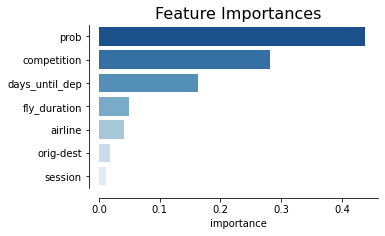

In [35]:
plot_feature_importances(rf, X, y)

In [36]:
model = create_pipeline(rf)

In [37]:
# training 
model.fit(X, y);

Accuracy: 0.77
F1-Score: 0.82
ROC AUC: 0.74


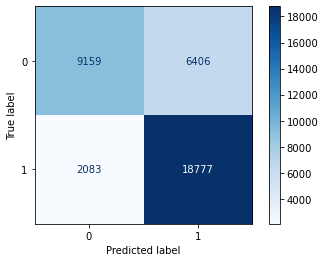

In [40]:
# eval on training
get_metrics(model, X, y)

## 4. Evaluation on validation

In order to evaluate the model we have to simulate a number of passengers wishing to buy airline tickets on certain days, apply the model predictions and check how much money they have saved if the model predicted they had to wait.
\


In [41]:
def get_min_prices_df(flights):
    """ 
        Return dataframe with min prices for each pair departure date/days until 
        departure and labeled according to the number of days remaining 
        until flight departure.
    """
    # getting minimum prices
    min_prices = flights.groupby(['orig-dest','dDate','days_until_dep'])['price'].min().reset_index()
    
    # list daily prices for each itinerary 
    list_prices = min_prices.groupby(['orig-dest', 'dDate'])['price'].agg(list).reset_index()
    list_prices.rename(columns={"price":"list_prices"}, inplace=True)
    min_prices['list_prices'] = pd.merge(min_prices, list_prices, on=['orig-dest','dDate']).reset_index()['list_prices']
    
    # label wait or buy according next days on list prices 
    min_prices['wait'] = min_prices.apply(get_actual_labels, axis=1)
    
    return min_prices

In [42]:
min_prices = get_min_prices_df(valid)

In [455]:
def get_test_flights(flights, min_prices, n=10000, random_state=42,):
    """ 
        Create dataframe with test flights for perform predictions.
        Steps:
            1. Generate n travelers
            2. Assign to each passenger the cheapest flight available
            3. Add needed features for model using training flights groups
            4. Add label from min_prices dataframe (target for our predictions)
    """
    # generate travelers: (id, collectionDate, orig-dest, dDate)
    travelers = flights[flights['days_until_dep']>=7][['collectionDate']+['orig-dest', 'dDate']].sample(n, random_state=random_state)
    travelers['id'] = np.arange(n)
    
    # assinging cheapest flights to travelers
    travelers_flights = pd.merge(travelers, flights, on=['collectionDate']+['orig-dest', 'dDate'])
    cheapest_flights = travelers_flights.groupby('id')['price'].idxmin()
    test_flights = travelers_flights.iloc[cheapest_flights]
    
    # adding 'competition' and 'prob' columns from train
    test_flights = pd.merge(test_flights, train[['competition', 'prob']+agg_cols], on=agg_cols, how='left')
    
    # adding 'wait' col (actual labels) from min_prices df
    test_flights = pd.merge(test_flights, min_prices[['orig-dest', 'dDate','days_until_dep', 'wait']], on=['orig-dest', 'dDate','days_until_dep'], how='left')
    
    return test_flights

In [46]:
valid_flights = get_test_flights(valid) 

Accuracy: 0.49
F1-Score: 0.29
ROC AUC: 0.54


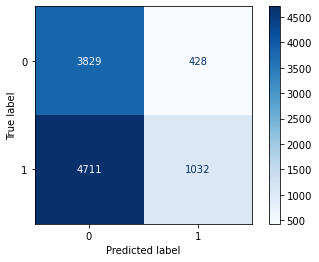

In [47]:
# make predictions
X_valid = valid_flights[cat+num]
y_valid = valid_flights['wait'].values

valid_flights['predicted'] = model.predict(X_valid)
probs = model.predict_proba(X_valid)

get_metrics(model, X_valid, y_valid)

In [410]:
def make_predictions(test_flights, model):
    X_valid = test_flights[cat+num]
    y_valid = test_flights['wait'].values

    test_flights['predicted'] = model.predict(X_valid)
    probs = model.predict_proba(X_valid)
    test_flights['wait_prob'] = probs[:,1]
    return test_flights

In [454]:
def compute_savings(test_flights, min_prices_df):
    """ Given wait predictions estimate days to wait and compute savings comparing prices. """
    # get just with predicted wait rows
    wait = test_flights[(test_flights['predicted'] == 1) & (test_flights['days_until_dep'] >= 7)].copy()
    
    # adding estimated prices
    list_prices = price_bins.groupby(['orig-dest','airline'])['price_est'].agg(list).rename('list_price_est').reset_index()
    wait = pd.merge(wait, list_prices, on=['orig-dest','airline'], how='left')
    wait = pd.merge(wait, bins_days, on='days_until_dep', how='left')
    
    wait['price_min_bin'] = wait.apply(get_estimated_price, axis=1)
    wait['min_bin'] = wait['price_min_bin'].apply(lambda x: x[1])
    wait['price_est'] = wait['price_min_bin'].apply(lambda x: x[0])
    wait['current_price_est'] = wait['price_min_bin'].apply(lambda x: x[2])
    wait.drop('price_min_bin', axis=1, inplace=True)
    
    # compute drop percentage
    wait['drop_per'] = ((1-wait['price_est']/wait['current_price_est'])*100).round()
    
    # days to wait
    wait['min_wait'] = wait['days_until_dep'] - (wait['min_bin']*5+6)
    wait['max_wait'] = wait['days_until_dep'] - (wait['min_bin']*5+2)
    
    # adding wait price
    wait = pd.merge(wait, min_prices_df[['orig-dest', 'dDate', 'list_prices', 'days_until_dep']], on=['orig-dest', 'dDate', 'days_until_dep'])
    wait['wait_price'] = wait.apply(get_wait_prices, axis=1)
    
    # savings
    wait['savings'] = wait['price'] - wait['wait_price']
    
    # merge with full dataframe
    final_df = pd.merge(test_flights, wait, how='left')
    
    # if less than a week for departure we will predict 'buy'
    final_df.loc[final_df['days_until_dep']<7, 'predicted'] = 0
    
    return final_df

In [49]:
res = compute_savings(valid_flights)

In [415]:
def report_results(df):
    # TOTAL RESULTS
    savings = df[df['savings'] > 0]['savings'].sum()
    losses = df[df['savings'] < 0]['savings'].sum()
    accuracy = accuracy_score(df['wait'], df['predicted'])*100
    f1 = f1_score(df['wait'],  df['predicted'])*100
    df['saving_per'] = df['savings']/df['price']
    saving_per = (df.groupby('orig-dest')['saving_per'].mean()*100).round(2).astype('str') + '%'
    
    res_total = pd.DataFrame({
    'Model': model['model'].__class__.__name__,
    'Savings (k€)': round(savings/1000, 1),
    'Losses (k€)': round(losses/1000, 1),
    'Mean (%)': round(df['saving_per'].mean(), 2)*100,
    'Accuracy': str(round(accuracy, 2)) + '%',
    'f1-score': str(round(f1, 2)) + '%',
    }, index=['0'])
    
    print(res_total.to_string(index=False)+'\n\n')
    
    # RESULTS BY ROUTE
    savings = (df[df['savings'] > 0].groupby('orig-dest')[['savings']].sum()/1000).round(1)
    losses = (df[df['savings'] <= 0].groupby('orig-dest')[['savings']].sum()/1000).round(1)
    wait_per = (df.groupby('orig-dest')['predicted'].mean()*100).round(2).astype('str') + '%'
    mean_savings = df.groupby('orig-dest')['savings'].mean()
    df['correct'] = (df['predicted'] == df['wait']) & (df['wait']==1)
    accuracy = (df.groupby('orig-dest')['correct'].mean()*100).round(2).astype('str') + '%'

    

    res_byroute = pd.DataFrame({
        'Savings (k€)': savings['savings'],
        'Losses (k€)': losses['savings'],
        'Mean Savings (€)': round(mean_savings, 2),
        'Savings Percentage': saving_per,
        'Wait predicted': wait_per,
        'Wait correctly predicted': accuracy,
    }, index=savings.index)
    
    
    print(res_byroute.to_string())

In [400]:
def plot_results(df):
    savings = df[df['savings'] > 0].groupby('orig-dest')[['savings']].sum().astype(int).reset_index()
    losses = df[df['savings'] < 0].groupby('orig-dest')[['savings']].sum().astype(int).reset_index()
    plt.figure(figsize=(8,6))
    g = sns.barplot(x='savings', y='orig-dest', data=savings, color='seagreen', );
    g2 = sns.barplot(x='savings', y='orig-dest', data=losses, color='darksalmon');
    #g.spines['left'].set_position(('axes', 0))
    
    # values text
    for index, row in savings.iterrows():
        g.text(row['savings']+600, index+0.10, str(row['savings'])+' €' , color='darkgreen', ha="center")
    for index, row in losses.iterrows():
        g2.text(row['savings']-600, index+0.10, str(row['savings'])+' €' , color='darkred', ha="center")
    
    sns.despine(left=False, bottom=True)
    # remove x axis
    plt.yticks(fontsize=14)
    plt.xticks([])
    plt.xlabel(None)
    plt.ylabel(None)
    lim = savings['savings'].max()
    plt.xlim(-lim,lim)

In [402]:
report_results(res)

                 Model  Savings (k€)  Losses (k€)  Mean (%) Accuracy f1-score
RandomForestClassifier          19.3         -4.0       9.0   48.61%   28.65%


           Savings (k€)  Losses (k€)  Mean Savings (€) Savings Percentage Wait predicted Wait correctly predicted
orig-dest                                                                                                        
BCN-AMS             3.9         -1.0             10.29              7.94%         18.16%                    11.2%
BCN-FCO             2.5         -0.7              7.24              8.62%         19.89%                   15.42%
BCN-LGW             1.9         -0.1             17.99              18.4%         21.52%                   18.04%
BCN-PMI             0.7         -0.0              5.75             21.78%          19.4%                   16.69%
MAD-BCN             0.1         -0.0              2.72              6.05%          4.04%                    3.25%
MAD-EZE             0.4         -0.2        

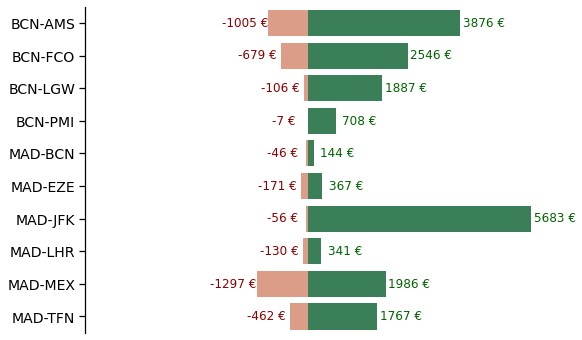

In [401]:
plot_results(res)

In [479]:
# function for evaluation in one step
def eval_model(test_data, model, plot_savings=False):
    
    min_prices = get_min_prices_df(test_data)
    test_flights = get_test_flights(test_data, min_prices)
    
    test_flights = make_predictions(test_flights, model)
    
    df_results = compute_savings(test_flights, min_prices)
    report_results(df_results)
    if plot_savings:
        plot_results(df_results)
    acc = accuracy_score(df_results['wait'], df_results['predicted'])*100
    return df_results['saving_per'].mean(), acc

                 Model  Savings (k€)  Losses (k€)  Mean (%) Accuracy f1-score
RandomForestClassifier          19.3         -4.0       9.0   48.61%   28.65%


           Savings (k€)  Losses (k€)  Mean Savings (€) Savings Percentage Wait predicted Wait correctly predicted
orig-dest                                                                                                        
BCN-AMS             3.9         -1.0             10.29              7.94%         18.16%                    11.2%
BCN-FCO             2.5         -0.7              7.24              8.62%         19.89%                   15.42%
BCN-LGW             1.9         -0.1             17.99              18.4%         21.52%                   18.04%
BCN-PMI             0.7         -0.0              5.75             21.78%          19.4%                   16.69%
MAD-BCN             0.1         -0.0              2.72              6.05%          4.04%                    3.25%
MAD-EZE             0.4         -0.2        

(0.09390465261748213, 48.61)

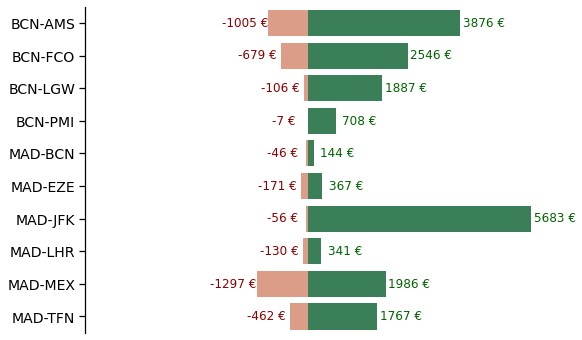

In [480]:
eval_model(test_data=valid, model=model, plot_savings=True)

## 5. Best model evaluation on test

In [481]:
savings_score, accuracy = eval_model(test_data=test, model=model)

                 Model  Savings (k€)  Losses (k€)  Mean (%) Accuracy f1-score
RandomForestClassifier          19.7         -3.8      10.0   48.44%   28.01%


           Savings (k€)  Losses (k€)  Mean Savings (€) Savings Percentage Wait predicted Wait correctly predicted
orig-dest                                                                                                        
BCN-AMS             2.7         -1.3              5.48              2.36%         16.19%                   10.34%
BCN-FCO             1.8         -0.3              5.80              8.14%         19.19%                    14.5%
BCN-LGW             2.2         -0.1             18.62             17.25%         25.11%                   17.11%
BCN-PMI             1.2         -0.1              8.22             32.79%         20.65%                   16.33%
MAD-BCN             0.1         -0.1             -0.21             -2.58%          3.59%                    1.42%
MAD-EZE             0.5         -0.2        

## 6. Store model for front-end

In [491]:
model_name = model['model'].__class__.__name__ + f'_savs-{savings_score:.2f}_acc-{accuracy:.2f}.pkl'
model_name

'RandomForestClassifier_savs-0.10_acc-48.44.pkl'

In [492]:
pickle.dump(model, open('../models/'+model_name, 'wb'))